In [2]:
import warnings; warnings.filterwarnings("ignore")
import os;
from sys import platform
print(os.getcwd())
if platform == "darwin":
    os.chdir('/Users/ziyingc/Dropbox/Lab/MotorCortex')
elif platform == "win32":
    os.chdir('D:\Dropbox\Lab\MotorCortex')
print(os.getcwd())
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormap module
import matplotlib.mlab as mlab 
from matplotlib.gridspec import GridSpec

import numpy as np
import nelpy as nel
import time
import scipy.signal as signal
import philters
import time2frequency as t2f
fs = 30000;
fps = 30;
fs_out = 1000
# rfdn = 'Rats/Rat_Quick/'
# rfdn = 'Rats/Rat_Solid/';ubset = np.array([4,12,52,60])
# rfdn = 'Rats/Rat_Astro/'; subset = np.array([5,12]);epn = np.load(rfdn+'epn_LT.npy');
# rfdn = 'Rats/Rat_Lenny/';subset = np.array([5,12])
# rfdn = 'Rats/Rat_C/';subset = np.array([5,12])
# rfdn = 'Rats/Rat_Quartus/';subset = np.array([4,12])
# rfdn = 'Rats/Rat_Unknown/'; subset = np.array([4,12,20,28])
# rfdn = 'Rats/New_Track/'
# rfdn = 'Rats/Rat_Drifter/';subset = np.array([4,12])
# rfdn = 'Rats/Rat_Swashbuckler/';subset = np.array([0,4])
rfdn = 'Rats/Rat_Outlaw/';subset = np.array([7,15]);epn = np.load(rfdn+'epn.npy');
fl = np.array([13,22,30,40])
fh = np.array([22,30,40,50])
np.save(rfdn+'fl.npy', fl)
np.save(rfdn+'fh.npy', fh)
n_band =len(fl)
N = int((1/fps)/(1/fs_out)/2); print(N)
N_std = 10

D:\Dropbox\Lab\MotorCortex
D:\Dropbox\Lab\MotorCortex
16


In [3]:
total_l = 0
total_l_rm = 0
for k in epn:
    fdn = rfdn + k + '/'
    t = np.load(fdn+'NPY_'+str(fs_out)+'/ts_ds.npy');
    idx_clean = t>-1; l_t = len(t)
    for ii in np.arange(2):
        for i in subset:   
            chn = str(i//10)+str(i%10)
            fn = 'NPY_'+str(fs_out)+'/ch.'+chn+'.npy'
            x = np.load(fdn+fn);
            idx_t = np.arange(len(x))
            sigma_x = np.std(x[idx_clean]);mu_x = np.mean(x[idx_clean])
            idx_arf = idx_t[np.absolute(x-mu_x)>sigma_x*N_std]
            for ii in idx_arf:
                idx_clean[ii-3*fs_out:ii+3*fs_out] = False
    total_l = total_l+len(t)
    total_l_rm = total_l_rm+len(t[idx_clean])
    np.save(fdn + 'NPY_'+str(fs_out)+'/idx_clean.npy', idx_clean)
print(np.round(total_l_rm/total_l,3))

0.978


In [13]:
for k in epn:
    fdn = rfdn+k+'/'

    ts_ds = np.load(fdn+'NPY_'+str(fs_out)+'/ts_ds.npy')
    timestamps = np.load(fdn+'tracking/'+'time_frame.npy')
    idx_clean = np.load(fdn + 'NPY_'+str(fs_out)+'/idx_clean.npy')
    
    l_t = len(ts_ds)
    idx = np.empty([0,])
    for i in timestamps:
        #index of each frame in filtered raw signal time serie
        idx = np.append(idx, np.searchsorted(ts_ds, i));
    
    idx = idx[np.logical_and(idx>N, idx<l_t-N)]
    idx = idx.astype('int');jj=0
    idx_t = np.arange(len(idx))
    idx_clean_f = idx_t>-1
    for j in idx:
        idx_clean_f[jj] = np.sum(idx_clean[j-N:j+N])==2*N;jj = jj+1;
    np.save(fdn+'NPY_'+str(fs_out)+'/idx_clean_f.npy',idx_clean_f)
    
#     window = np.ones((N*2,))/(N*2)
    window = np.hanning(N*2);
    for i in subset:
        chn = str(i//10)+str(i%10)
        x_f = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'.npy')
        x_f = (x_f-np.mean(x_f[idx_clean]))/np.std(x_f[idx_clean])
        
        S_f = (x_f**2)   #**0.5;
        S_f_mean_clean = np.mean(S_f[idx_clean]);
        S_f_median_clean = np.median(S_f[idx_clean]);
        S_f_std_clean = np.std(S_f[idx_clean]);
        
        S_f_mean = np.mean(S_f);
        S_f_median = np.median(S_f);
        S_f_std = np.std(S_f);
        
        sig = nel.AnalogSignalArray(data=x_f, timestamps=ts_ds, fs=fs_out)
        X_f = np.zeros((n_band,len(x_f)))
        
        for j in np.arange(n_band):
            lfp_f = nel.filtering.sosfiltfilt(sig, fl=fl[j], fh=fh[j])
            y_f = lfp_f.ydata[0]
#             y_f = (y_f-np.mean(y_f[idx_clean]))/np.std(y_f[idx_clean])
            # squared sample values
            X_f[j,:] = y_f**2 
        # averaging squared sample values within the frame
        X_f = t2f.frame_clean(X_f, idx, window)
        #root the mean squared value of the frame
#         X_f = X_f**0.5
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_bf.npy', X_f)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S.npy', S_f)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_mean.npy', S_f_mean)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_median.npy', S_f_median)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_std.npy', S_f_std)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_mean_clean.npy', S_f_mean_clean)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_median_clean.npy', S_f_median_clean)
        np.save(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_std_clean.npy', S_f_std_clean)

In [15]:
for k in epn:
    fdn = rfdn+k+'/'

#     timestamps = np.load(fdn+'NPY_'+str(fs_out)+'/ts_ds.npy');
#     idx_clean = np.load(fdn + 'NPY_'+str(fs_out)+'/idx_clean.npy')
    timestamps = np.load(fdn+'tracking/'+'ts_f.npy')
    idx_clean = np.load(fdn+'NPY_'+str(fs_out)+'/idx_clean_f.npy')
    print(k[10:21], np.round(len(timestamps[idx_clean])/len(timestamps),3))
    fig = plt.figure(1, figsize=(16, 8))
    gs = GridSpec(n_band ,1);jj = 1
    for i in subset:
        chn = str(i//10)+str(i%10)
        X_f = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_bf.npy').T
        for j in np.arange(n_band):
            ax_idx = gs[j,0];  ax = fig.add_subplot(ax_idx);
            X_f_j = X_f[j,:]
            ax.plot(timestamps[0:300], X_f_j[0:300],'-');
#             ax.set_ylim([0,1])
#             ax.set_title(str(fl[j])+ ' Hz to '+str(fh[j])+' Hz')
    plt.savefig(rfdn+'pic2/'+k+'_Power.png')
    plt.clf()

190531_1402 0.952
190531_1407 0.989
190601_1315 1.0
190601_1320 1.0
190603_1033 1.0
190603_1040 1.0
190603_1053 1.0
190604_1215 0.991
190604_1226 1.0
190604_1233 0.955
190604_1242 1.0
190605_1210 1.0
190605_1215 1.0
190605_1229 1.0
190605_1538 0.983
190605_1551 1.0
190607_1537 0.984
190610_0955 0.944
190610_1040 0.883
190610_1137 0.894
190610_1140 1.0
190610_1517 0.987
190611_1126 0.858
190611_1140 0.739
190612_1118 0.852
190613_1302 0.967
190613_1307 0.953
190613_1312 0.822
190617_1146 0.952
190618_1123 1.0
190618_1153 1.0
190618_1140 1.0
190618_1202 1.0
190618_1209 1.0
190618_1213 1.0
190618_1218 0.977
190619_1316 1.0
190620_1118 1.0
190620_1226 1.0
190627_1630 1.0


<Figure size 1152x576 with 0 Axes>

(40,) (40,)
0.0 0.0
0.04137 0.0471
0.03769 0.03981
1.0975 1.0


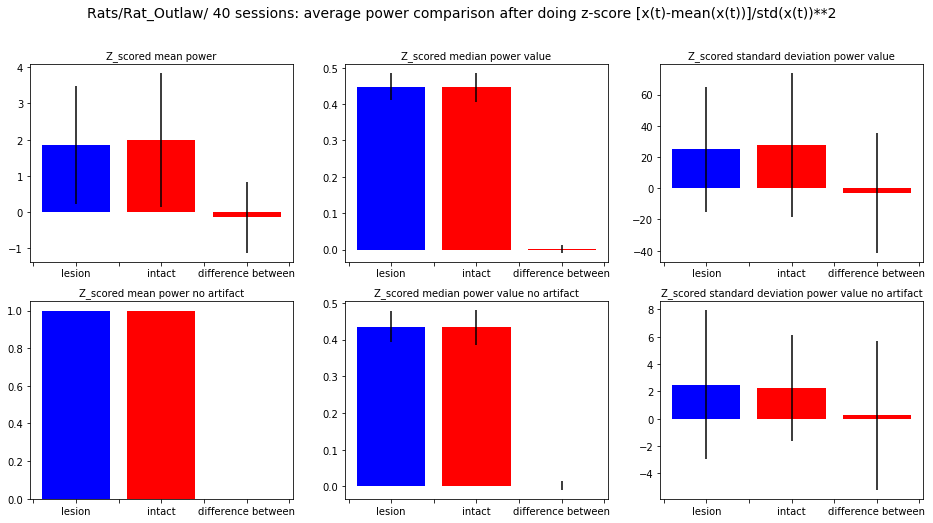

In [11]:
S_f_mean   = np.zeros((2,len(epn)));
S_f_median = np.zeros((2,len(epn)));
S_f_std    = np.zeros((2,len(epn)));
S_f_mean_clean   = np.zeros((2,len(epn)));
S_f_median_clean = np.zeros((2,len(epn)));
S_f_std_clean    = np.zeros((2,len(epn)));
ii = 0
for k in epn:
    fdn = rfdn+k+'/'
    jj = 0
    for i in subset:
        chn = str(i//10)+str(i%10)
        S_f_mean[jj,ii]   = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_mean.npy')
        S_f_median[jj,ii] = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_median.npy')
        S_f_std[jj,ii]    = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_std.npy')
        S_f_mean_clean[jj,ii]   = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_mean_clean.npy')
        S_f_median_clean[jj,ii] = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_median_clean.npy')
        S_f_std_clean[jj,ii]    = np.load(fdn+'NPY_'+str(fs_out)+'/ch.'+chn+'_z_S_std_clean.npy')
        jj = jj+1
    ii = ii+1
tag = 'no artifact'
fig = plt.figure(1, figsize=(16, 8))
gs = GridSpec(2 ,3);
fig.suptitle(rfdn+' '+str(len(epn))+' sessions: average power comparison after doing z-score [x(t)-mean(x(t))]/std(x(t))**2', fontsize=14)
ax_idx = gs[0,0];  ax = fig.add_subplot(ax_idx);
ax.bar(1,np.mean(S_f_mean[0,:]), yerr=np.std(S_f_mean[0,:]),lw = 0.03, color = 'b')
ax.bar(2,np.mean(S_f_mean[1,:]), yerr=np.std(S_f_mean[1,:]),lw = 0.03, color = 'r')
ax.bar(3,np.mean(S_f_mean[0,:]-S_f_mean[1,:]), yerr=np.std(S_f_mean[0,:]-S_f_mean[1,:]),lw = 0.03, color = 'r')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'lesion'
labels[4] = 'intact'
labels[6] = 'difference between'
ax.set_xticklabels(labels);
# ax.set_ylim([-0.1,3])
ax.set_title('Z_scored mean power', fontsize = 10)

ax_idx = gs[0,1];  ax = fig.add_subplot(ax_idx);
ax.bar(1,np.mean(S_f_median[0,:]), yerr=np.std(S_f_median[0,:]),lw = 0.03, color = 'b')
ax.bar(2,np.mean(S_f_median[1,:]), yerr=np.std(S_f_median[1,:]),lw = 0.03, color = 'r')
ax.bar(3,np.mean(S_f_median[0,:]-S_f_median[1,:]), yerr=np.std(S_f_median[0,:]-S_f_median[1,:]),lw = 0.03, color = 'r')
ax.set_xticklabels(labels);
# ax.set_ylim([-0.1,3])
ax.set_title('Z_scored median power value', fontsize = 10)

ax_idx = gs[0,2];  ax = fig.add_subplot(ax_idx);
ax.bar(1,np.mean(S_f_std[0,:]), yerr=np.std(S_f_std[0,:]),lw = 0.03, color = 'b')
ax.bar(2,np.mean(S_f_std[1,:]), yerr=np.std(S_f_std[1,:]),lw = 0.03, color = 'r')
ax.bar(3,np.mean(S_f_std[0,:]-S_f_std[1,:]), yerr=np.std(S_f_std[0,:]-S_f_mean[1,:]),lw = 0.03, color = 'r')
ax.set_xticklabels(labels, fontsize = 10);
ax.set_title('Z_scored standard deviation power value', fontsize = 10)


ax_idx = gs[1,0];  ax = fig.add_subplot(ax_idx);
ax.bar(1,np.mean(S_f_mean_clean[0,:]), yerr=np.std(S_f_mean_clean[0,:]),lw = 0.03, color = 'b')
ax.bar(2,np.mean(S_f_mean_clean[1,:]), yerr=np.std(S_f_mean_clean[1,:]),lw = 0.03, color = 'r')
ax.bar(3,np.mean(S_f_mean_clean[0,:]-S_f_mean_clean[1,:]), yerr=np.std(S_f_mean_clean[0,:]-S_f_mean_clean[1,:]),lw = 0.03, color = 'r')
print(S_f_mean[0,:].shape, S_f_mean[1,:].shape)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[2] = 'lesion'
labels[4] = 'intact'
labels[6] = 'difference between'
ax.set_xticklabels(labels);
# ax.set_ylim([-0.1,3])
ax.set_title('Z_scored mean power '+tag, fontsize = 10)

ax_idx = gs[1,1];  ax = fig.add_subplot(ax_idx);
ax.bar(1,np.mean(S_f_median_clean[0,:]), yerr=np.std(S_f_median_clean[0,:]),lw = 0.03, color = 'b')
ax.bar(2,np.mean(S_f_median_clean[1,:]), yerr=np.std(S_f_median_clean[1,:]),lw = 0.03, color = 'r')
ax.bar(3,np.mean(S_f_median_clean[0,:]-S_f_median_clean[1,:]), yerr=np.std(S_f_median_clean[0,:]-S_f_median_clean[1,:]),lw = 0.03, color = 'r')
ax.set_xticklabels(labels);
# ax.set_ylim([-0.1,3])
ax.set_title('Z_scored median power value '+tag, fontsize = 10)

ax_idx = gs[1,2];  ax = fig.add_subplot(ax_idx);
ax.bar(1,np.mean(S_f_std_clean[0,:]), yerr=np.std(S_f_std_clean[0,:]),lw = 0.03, color = 'b')
ax.bar(2,np.mean(S_f_std_clean[1,:]), yerr=np.std(S_f_std_clean[1,:]),lw = 0.03, color = 'r')
ax.bar(3,np.mean(S_f_std_clean[0,:]-S_f_std_clean[1,:]), yerr=np.std(S_f_std_clean[0,:]-S_f_mean_clean[1,:]),lw = 0.03, color = 'r')
ax.set_xticklabels(labels, fontsize = 10);
ax.set_title('Z_scored standard deviation power value '+tag, fontsize = 10)

print(np.round(np.std(S_f_mean_clean[0,:]),5), np.round(np.std(S_f_mean_clean[1,:]),5))
print(np.round(np.std(S_f_median_clean[0,:]),5), np.round(np.std(S_f_median_clean[1,:]),5))
print(np.round(np.std(S_f_median[0,:]),5),       np.round(np.std(S_f_median[1,:]),5))
print(np.round(np.std(S_f_median_clean[0,:])/np.std(S_f_median[0,:]),5), 
      np.round(np.std(S_f_median_clean[1,:])/np.round(np.std(S_f_median[1,:]),5)))

In [17]:
for k in epn:
    fdn = rfdn + k + '/'
    ts_ds = np.load(fdn+'NPY_'+str(fs_out)+'/ts_ds.npy');
    timestamps = np.load(fdn+'tracking/'+'time_frame.npy')

    l_t = len(ts_ds)
    idx = np.empty([0,])
    for i in timestamps:
        idx = np.append(idx, np.searchsorted(ts_ds, i));

    XY = np.load(fdn+'tracking/'+'position2D_frame.npy');
    wells = np.load(fdn+'tracking/' + 'wells.npy')
    ts_f = timestamps[np.logical_and(idx>N, idx<l_t-N)];np.save(fdn+'tracking/'+'ts_f.npy', ts_f)
    XY_f      =    XY[np.logical_and(idx>N, idx<l_t-N)];np.save(fdn+'tracking/'+'XY_f.npy', XY_f)
    wells_f   = wells[np.logical_and(idx>N, idx<l_t-N)];np.save(fdn+'tracking/'+'wells_f.npy', wells_f)
